# Pre-processing and Training

## 1 Contents
- [1 Contents](#1-Contents)
- [2 Introduction](#2-Introduction)
- [3 Imports](#3-Imports)
- [4 Load Data](#4-Load-Data)
- [5 Preparing Data](#5-Preparing-Data)
  - [5.1 Dataset creation](#5.1-Dataset-creation)
    - [5.1.1 Completing years](#5.1.1-Completing-years)
    - [5.1.2 Adding area](#5.1.2-Adding-area)
    - [5.1.3 Dummy encoding counties](#5.1.3-Dummy-encoding-counties)
  - [5.2 Split the data into training and testing sets](#5.2-Split-the-data-into-training-and-testing-sets)
- [6 Summary](#6-Summary)
  - [6.1 Save train/test sets](#6.1-Save-train/test-sets)

## 2 Introduction

The purpose of this notebook is to prepare the data for modeling, which may include standardization or encoding. At this time, the data will also be split into a training and testing set.

The first approach that will be attempted is to see if we can develop a model that can determine how many fires will be in each county in some years. The target feature is the number of fires in a county, and the independent variable is the area in square miles.

## 3 Imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## 4 Load Data

The data needed for our approach are the area of the county and the fires that occurred. These would be found in the `fire_df` and the `county_df`.

In [2]:
fire_df = pd.read_pickle('../data/interim/2-1_fire_df.pkl')
county_df = pd.read_pickle('../data/interim/2-1_county_df.pkl')

In [3]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   AcresBurned            1603 non-null   float64            
 1   CalFireIncident        1605 non-null   bool               
 2   CanonicalUrl           1605 non-null   object             
 3   County                 1605 non-null   object             
 4   CountyIds              1605 non-null   object             
 5   ExtinguishedTimestamp  1605 non-null   datetime64[ns, UTC]
 6   Featured               1605 non-null   bool               
 7   Latitude               1605 non-null   float64            
 8   Longitude              1605 non-null   float64            
 9   MajorIncident          1605 non-null   bool               
 10  Name                   1605 non-null   object             
 11  StartedTimestamp       1605 non-null   datetime64[ns, UT

In [4]:
county_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   countyId           58 non-null     int64  
 1   County             58 non-null     object 
 2   Latitude           58 non-null     float64
 3   Longitude          58 non-null     float64
 4   AcresBurned        56 non-null     float64
 5   FireStartCounts    56 non-null     float64
 6   AcresPerFireCount  56 non-null     float64
 7   Population_2022    58 non-null     int64  
 8   Area_sqmi          58 non-null     int64  
 9   Pop_per_size       58 non-null     float64
 10  StartProportion    56 non-null     float64
dtypes: float64(7), int64(3), object(1)
memory usage: 5.4+ KB


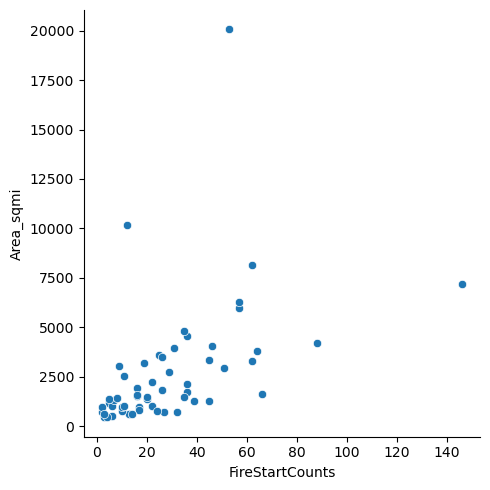

In [5]:
g = sns.relplot(data=county_df, x='FireStartCounts', y='Area_sqmi')
plt.show()

## 5 Preparing Data

### 5.1 Dataset creation

A new dataframe will be made that needs the following: the county, the number of fires per year in the county, and the area.

In [6]:
fcount_df = fire_df[['County', 'StartedYear', 'UniqueId']].groupby(['County', 'StartedYear']).count()

In [7]:
fcount_df.rename(columns={'UniqueId':'NumFires'}, inplace=True)

In [8]:
fcount_df.reset_index(inplace=True)

In [9]:
fcount_df.head(3)

,County,StartedYear,NumFires
0,Alameda,2013,4
1,Alameda,2015,5
2,Alameda,2016,1


In [10]:
fcount_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   County       328 non-null    object
 1   StartedYear  328 non-null    int64 
 2   NumFires     328 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.8+ KB


#### 5.1.1 Completing years

For each county, there should be an entry for every year. Currently we have 328 entries, but for 56 counties, there should be 392 entries. In the end, we should have 64 rows with 0 `NumFires`.

In [11]:
years = np.arange(fcount_df['StartedYear'].min(),fcount_df['StartedYear'].max() + 1)
counties = fcount_df.County.unique()

In [12]:
# Making an empty DataFrame of the goal size
zero_df = pd.DataFrame(0, index=np.arange(len(years) * len(counties)), columns=fcount_df.columns[0:2])
zero_df

,County,StartedYear
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
387,0,0
388,0,0
389,0,0
390,0,0


In [13]:
# Instantiating values such that there are 7 years [2013,2019] for every county
i = 0
for c in counties:
    for y in years:
        zero_df.iloc[i] = [c, y]
        i += 1

In [14]:
# Verifying there are the same number of counties as in the original fcount_df
print(zero_df['County'].nunique(), fcount_df['County'].nunique())

56 56


In [15]:
# Verifying the 7 unique years
print(zero_df['StartedYear'].unique())

[2013 2014 2015 2016 2017 2018 2019]


In [16]:
# Verifying 7 entries for each County
zero_df['County'].value_counts()

Alameda            7
Alpine             7
Plumas             7
Riverside          7
Sacramento         7
San Benito         7
San Bernardino     7
San Diego          7
San Joaquin        7
San Luis Obispo    7
San Mateo          7
Santa Barbara      7
Santa Clara        7
Santa Cruz         7
Shasta             7
Sierra             7
Siskiyou           7
Solano             7
Sonoma             7
Stanislaus         7
Sutter             7
Tehama             7
Trinity            7
Tulare             7
Tuolumne           7
Ventura            7
Yolo               7
Placer             7
Orange             7
Nevada             7
Kern               7
Amador             7
Butte              7
Calaveras          7
Colusa             7
Contra Costa       7
Del Norte          7
El Dorado          7
Fresno             7
Glenn              7
Humboldt           7
Inyo               7
Kings              7
Napa               7
Lake               7
Lassen             7
Los Angeles        7
Madera       

In [17]:
zero_df

,County,StartedYear
0,Alameda,2013
1,Alameda,2014
2,Alameda,2015
3,Alameda,2016
4,Alameda,2017
...,...,...
387,Yuba,2015
388,Yuba,2016
389,Yuba,2017
390,Yuba,2018


In [18]:
allyears_df = fcount_df.merge(zero_df, how='outer', on=['County','StartedYear'])

In [19]:
allyears_df

,County,StartedYear,NumFires
0,Alameda,2013,4.0
1,Alameda,2015,5.0
2,Alameda,2016,1.0
3,Alameda,2017,5.0
4,Alameda,2018,8.0
...,...,...,...
387,Trinity,2016,NaN
388,Tulare,2014,NaN
389,Yolo,2015,NaN
390,Yuba,2014,NaN


In [20]:
allyears_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   County       392 non-null    object 
 1   StartedYear  392 non-null    int64  
 2   NumFires     328 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.2+ KB


In [21]:
allyears_df[allyears_df['County'] == 'Yuba']

,County,StartedYear,NumFires
323,Yuba,2013,1.0
324,Yuba,2015,2.0
325,Yuba,2016,1.0
326,Yuba,2017,6.0
327,Yuba,2019,4.0
390,Yuba,2014,NaN
391,Yuba,2018,NaN


In [22]:
allyears_df.fillna(value={'NumFires':0}, inplace=True)

In [23]:
allyears_df[allyears_df['County'] == 'Yuba']

,County,StartedYear,NumFires
323,Yuba,2013,1.0
324,Yuba,2015,2.0
325,Yuba,2016,1.0
326,Yuba,2017,6.0
327,Yuba,2019,4.0
390,Yuba,2014,0.0
391,Yuba,2018,0.0


In [24]:
allyears_df.sort_values(by=['County', 'StartedYear'], inplace=True)
allyears_df.reset_index(drop=True, inplace=True)

In [25]:
allyears_df

,County,StartedYear,NumFires
0,Alameda,2013,4.0
1,Alameda,2014,0.0
2,Alameda,2015,5.0
3,Alameda,2016,1.0
4,Alameda,2017,5.0
...,...,...,...
387,Yuba,2015,2.0
388,Yuba,2016,1.0
389,Yuba,2017,6.0
390,Yuba,2018,0.0


In [26]:
# Check we have 64 0 fires
len(allyears_df[allyears_df['NumFires'] == 0])

64

In [27]:
len(allyears_df[allyears_df['NumFires'] == 0]) / len(allyears_df)

0.16326530612244897

In [28]:
allyears_df['NumFires'].describe()

count    392.000000
mean       4.094388
std        5.110920
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       52.000000
Name: NumFires, dtype: float64

In [29]:
allyears_df = allyears_df.astype({'NumFires':'int64'})

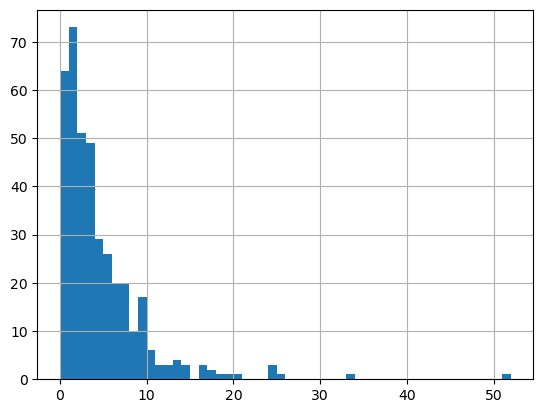

In [30]:
allyears_df['NumFires'].hist(bins=52)
plt.show()

In [31]:
fcount_df = allyears_df

#### 5.1.2 Adding area

In [32]:
fcount_df = fcount_df.merge(county_df[['County','Area_sqmi']], how='left', on='County')

In [33]:
fcount_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   County       392 non-null    object
 1   StartedYear  392 non-null    int64 
 2   NumFires     392 non-null    int64 
 3   Area_sqmi    392 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.3+ KB


In [34]:
fcount_df.sample(3)

,County,StartedYear,NumFires,Area_sqmi
214,Plumas,2017,5,2554
377,Ventura,2019,6,1846
37,Colusa,2015,0,1151


#### 5.1.3 Dummy encoding counties

In [35]:
# There are 56 in this DataFrame
fcount_df['County'].nunique()

56

In [36]:
# Alameda will probably be dropped
fcount_dummy_df = pd.get_dummies(fcount_df, columns=['County'], drop_first = True, prefix='DM')
print(fcount_dummy_df.columns)

Index(['StartedYear', 'NumFires', 'Area_sqmi', 'DM_Alpine', 'DM_Amador',
       'DM_Butte', 'DM_Calaveras', 'DM_Colusa', 'DM_Contra Costa',
       'DM_Del Norte', 'DM_El Dorado', 'DM_Fresno', 'DM_Glenn', 'DM_Humboldt',
       'DM_Inyo', 'DM_Kern', 'DM_Kings', 'DM_Lake', 'DM_Lassen',
       'DM_Los Angeles', 'DM_Madera', 'DM_Marin', 'DM_Mariposa',
       'DM_Mendocino', 'DM_Merced', 'DM_Modoc', 'DM_Mono', 'DM_Monterey',
       'DM_Napa', 'DM_Nevada', 'DM_Orange', 'DM_Placer', 'DM_Plumas',
       'DM_Riverside', 'DM_Sacramento', 'DM_San Benito', 'DM_San Bernardino',
       'DM_San Diego', 'DM_San Joaquin', 'DM_San Luis Obispo', 'DM_San Mateo',
       'DM_Santa Barbara', 'DM_Santa Clara', 'DM_Santa Cruz', 'DM_Shasta',
       'DM_Sierra', 'DM_Siskiyou', 'DM_Solano', 'DM_Sonoma', 'DM_Stanislaus',
       'DM_Sutter', 'DM_Tehama', 'DM_Trinity', 'DM_Tulare', 'DM_Tuolumne',
       'DM_Ventura', 'DM_Yolo', 'DM_Yuba'],
      dtype='object')


### 5.2 Split the data into training and testing sets

Setting aside the years 2018 and 2019 for testing, means that with 56 counties and 2 years, our test set should contain 112 rows, which is 28.6% of all of the data, and our training set would contain 280 rows.

In [37]:
test_df = fcount_dummy_df[fcount_dummy_df['StartedYear'] >= 2018]
len(test_df)

112

In [38]:
train_df = fcount_dummy_df[fcount_dummy_df['StartedYear'] < 2018]
len(train_df)

280

## 6 Summary

To prepare the data for model fitting, a new DataFrame containing the target feature and potential explanatory variables was creeated. The first approach requires the area of the county, the year, the numbers of fires that occurred, and the county. The negative cases were added to the dataset, so if there were no fires recorded for a county in a year, they were assigned 0 fires for that instance. Then the county was dummy encoded, with Alameda dropped. Finally, the set was split into a training and testing set, with the latter two years of 2018 and 2019 (about 28.6%) going into the test set and the remainder (2013-2017) going into the training set.

### 6.1 Save train/test sets

In [39]:
test_df.to_pickle('../data/processed/3-0_test_df.pkl')
train_df.to_pickle('../data/processed/3-0_train_df.pkl')